<a href="https://colab.research.google.com/github/sububack/MelDetect/blob/main/Subramanian_Karunanithi_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem statement:**
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


## **Importing Skin Cancer Data**

### **Importing all the important libraries**


In [45]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [46]:
### Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).




This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.


In [47]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/SkinCancer/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/SkinCancer/Test")

In [48]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [49]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.



In [50]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset='training',
                                                               label_mode='categorical', seed=123, image_size=(img_height,img_width), batch_size= batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [51]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset='validation',
                                                             label_mode='categorical', seed=123, image_size=(img_height,img_width), batch_size= batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [52]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### **Visualize the data**

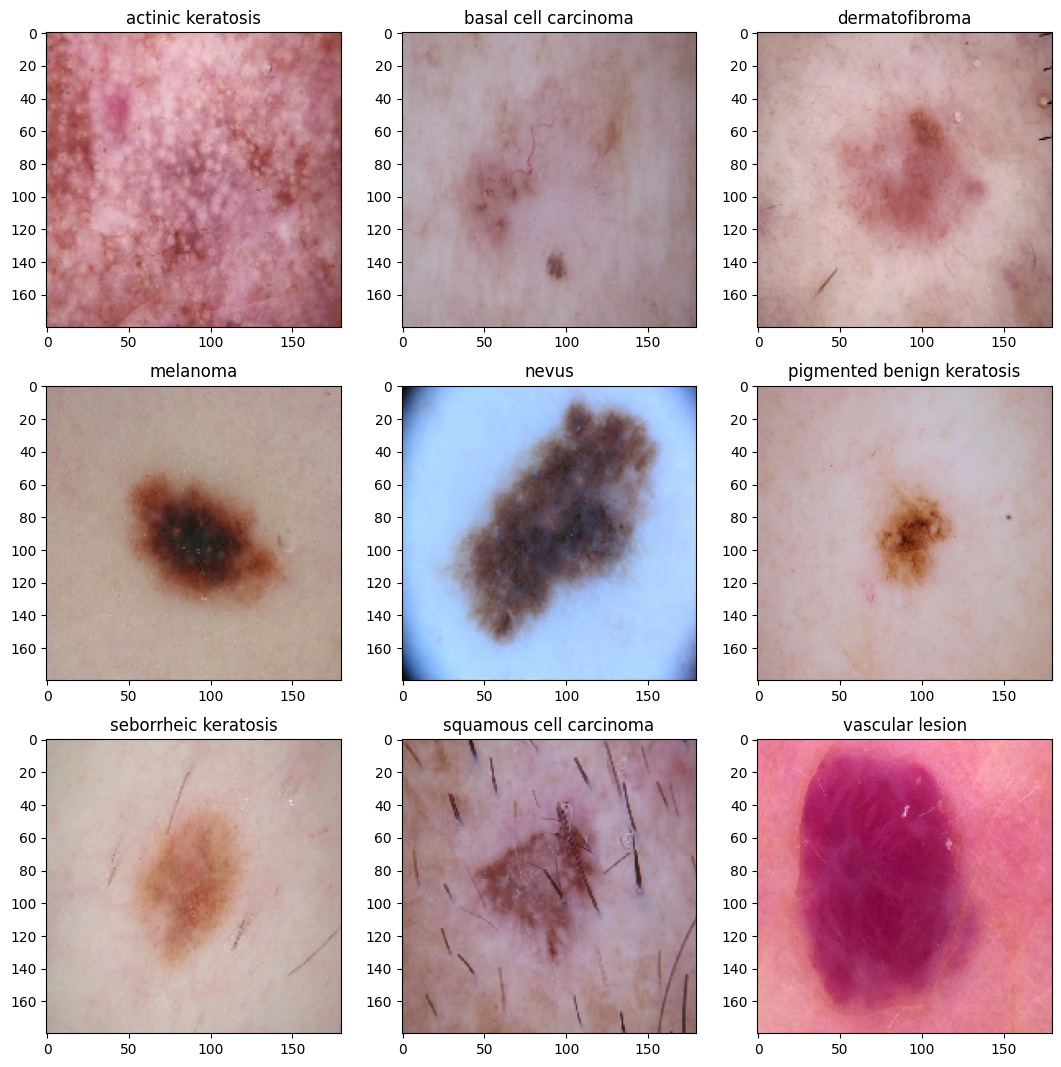

In [53]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image per class
files_path_dict = {}

for cls in class_names:
    files_path_dict[cls] = list(map(lambda x:str(data_dir_train)+'/'+cls+'/'+x,os.listdir(str(data_dir_train)+'/'+cls)))

#Visualize image
plt.figure(figsize=(13,13))
index = 0
for cls in class_names:
    path_list = files_path_dict[cls][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(cls)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.



In [54]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Create the model**
Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]


In [55]:
input_shape = (img_height,img_width,3)

model = Sequential()

#First Convulation Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(256,activation='relu'))

#Dense Layer with softmax activation function.
model.add(layers.Dense(len(class_names),activation='softmax'))

### **Compile the model**

In [56]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#View the summary of all layers


In [57]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)     

### **Train the model**

In [58]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 91ms/step - loss: 1.8768 - accuracy: 0.3064 - val_loss: 1.6145 - val_accuracy: 0.4273
Epoch 2/20
56/56 [==============================] - 2s 44ms/step - loss: 1.6393 - accuracy: 0.4124 - val_loss: 1.4601 - val_accuracy: 0.5145
Epoch 3/20
56/56 [==============================] - 2s 45ms/step - loss: 1.4908 - accuracy: 0.4727 - val_loss: 1.4678 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 2s 42ms/step - loss: 1.3731 - accuracy: 0.5223 - val_loss: 1.4421 - val_accuracy: 0.5324
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3484 - accuracy: 0.5195 - val_loss: 1.3973 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2564 - accuracy: 0.5480 - val_loss: 1.4029 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2067 - accuracy: 0.5798 - val_loss: 1.6809 - val_accuracy: 0.4966
Epoch 8/20
5

### **Visualizing training results**

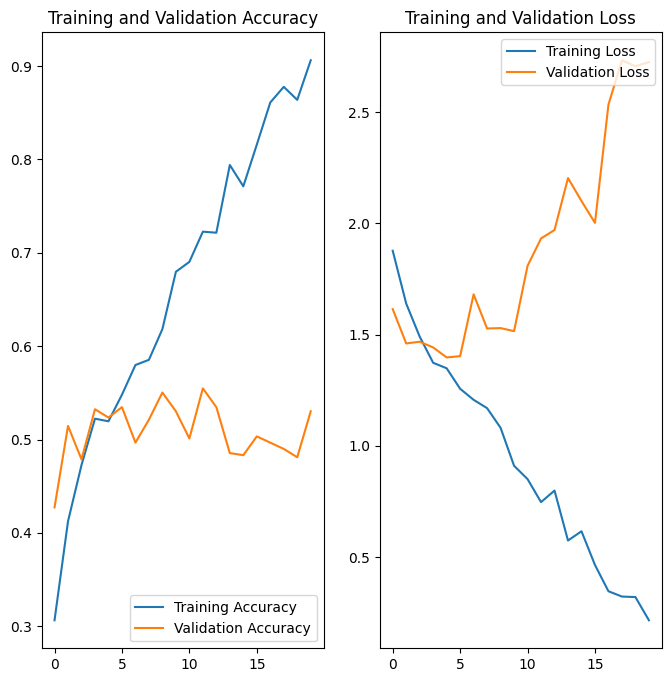

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:**

We can see that model is overfitting. To rectify we can apply few augmentation strategy












In [66]:
# Data augmentation strategy

#To rescale an input in the [0, 255] range to be in the [0, 1] range
rescale=tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_aug=tf.keras.Sequential([
    #Randomly flip each image horizontally and vertically
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=123),
    #Randomly change the contrast of an image by a certain factor
    layers.experimental.preprocessing.RandomContrast(0.2, seed=123),
    #Random rotation
    layers.experimental.preprocessing.RandomRotation(0.3, seed=123),
    #Random zooming
    layers.experimental.preprocessing.RandomZoom(0.2, seed=123)
])

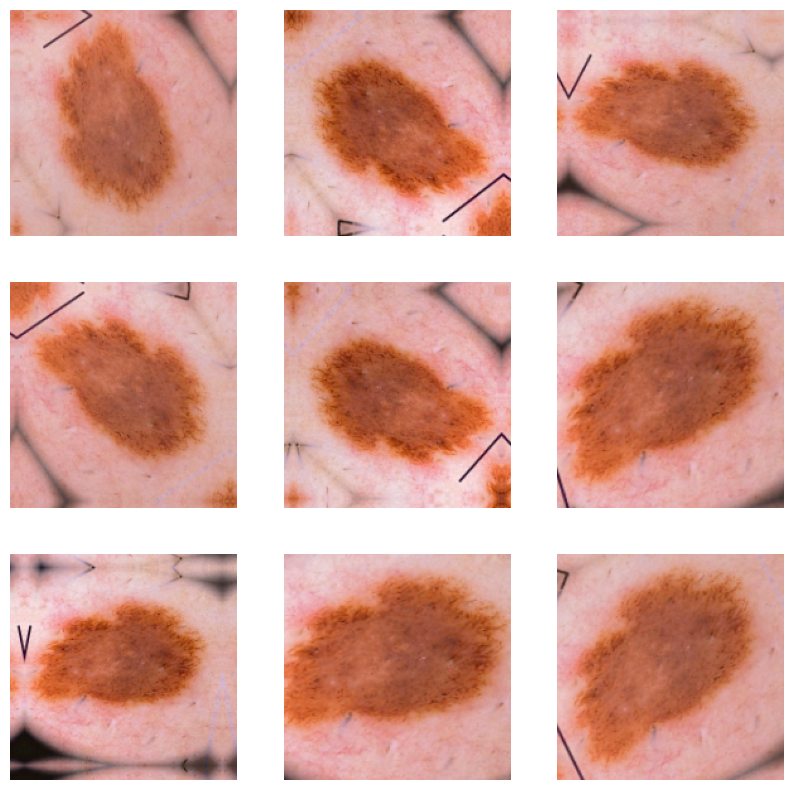

In [67]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_aug(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


### **Create the model, compile and train the model after data augmentation**


In [68]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


model_aug = Sequential()

model_aug.add(data_aug)
model_aug.add(rescale)

#First Convulation Layer
model_aug.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model_aug.add(layers.MaxPool2D(pool_size=(2,2)))
model_aug.add(layers.Dropout(0.25))

#Second Convulation Layer
model_aug.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model_aug.add(layers.MaxPool2D(pool_size=(2,2)))
model_aug.add(layers.Dropout(0.25))

#Third Convulation Layer
model_aug.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model_aug.add(layers.MaxPool2D(pool_size=(2,2)))
model_aug.add(layers.Dropout(0.25))

#Flatten layer
model_aug.add(layers.Flatten())

#Dense Layer
model_aug.add(layers.Dense(512,activation='relu'))
model_aug.add(layers.Dropout(0.5))

#Dense Layer
model_aug.add(layers.Dense(256,activation='relu'))
model_aug.add(layers.Dropout(0.5))


#Dense Layer with softmax activation function.
model_aug.add(layers.Dense(len(class_names),activation='softmax'))

### **Compiling the model**

In [69]:
model_aug.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### **Training the model**


In [70]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 71ms/step - loss: 2.4669 - accuracy: 0.1741 - val_loss: 2.1053 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 65ms/step - loss: 2.0562 - accuracy: 0.1964 - val_loss: 2.0806 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 4s 66ms/step - loss: 1.9911 - accuracy: 0.2305 - val_loss: 1.9082 - val_accuracy: 0.2416
Epoch 4/20
56/56 [==============================] - 4s 71ms/step - loss: 1.9080 - accuracy: 0.2796 - val_loss: 1.8617 - val_accuracy: 0.3356
Epoch 5/20
56/56 [==============================] - 4s 66ms/step - loss: 1.7333 - accuracy: 0.3666 - val_loss: 1.6656 - val_accuracy: 0.3960
Epoch 6/20
56/56 [==============================] - 4s 66ms/step - loss: 1.6822 - accuracy: 0.3705 - val_loss: 1.6270 - val_accuracy: 0.4094
Epoch 7/20
56/56 [==============================] - 4s 68ms/step - loss: 1.6428 - accuracy: 0.4029 - val_loss: 1.5848 - val_accuracy: 0.4609
Epoch 8/20
56

### **Visualizing the results**

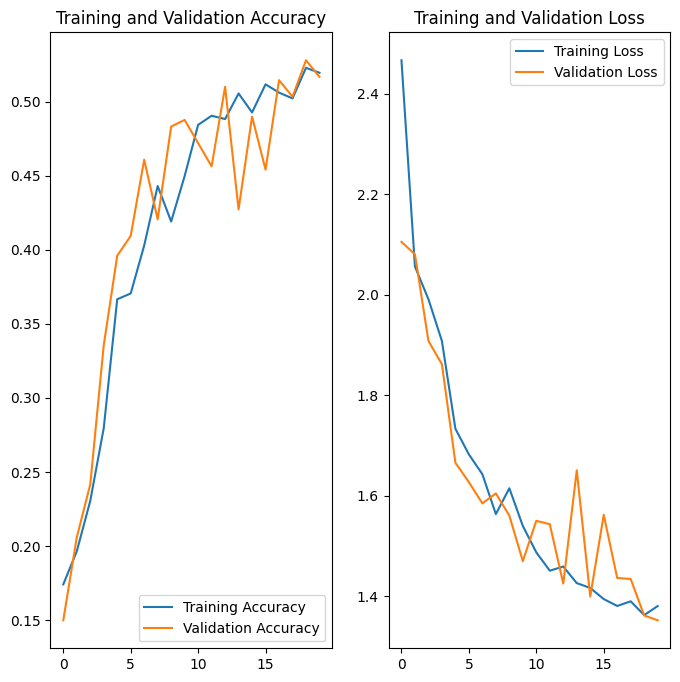

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Finding from Second Model**


After adding the augmentation layer and dropouts we have significantly reduced overfitting of the model. Although the accuracy is still poor we have at least managed to solve the overfitting problem.


**Todo**:

Find the distribution of classes in the training dataset.

**Context**:

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.


In [73]:
##
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df


,Path,Label
0,/content/gdrive/MyDrive/SkinCancer/Train/actin...,actinic keratosis
1,/content/gdrive/MyDrive/SkinCancer/Train/actin...,actinic keratosis
2,/content/gdrive/MyDrive/SkinCancer/Train/actin...,actinic keratosis
3,/content/gdrive/MyDrive/SkinCancer/Train/actin...,actinic keratosis
4,/content/gdrive/MyDrive/SkinCancer/Train/actin...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/SkinCancer/Train/vascu...,vascular lesion
2235,/content/gdrive/MyDrive/SkinCancer/Train/vascu...,vascular lesion
2236,/content/gdrive/MyDrive/SkinCancer/Train/vascu...,vascular lesion
2237,/content/gdrive/MyDrive/SkinCancer/Train/vascu...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


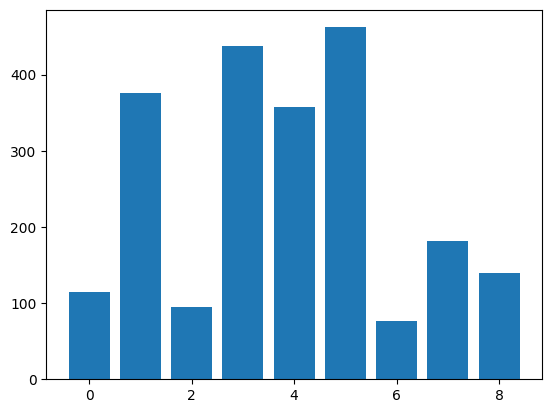

In [74]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [75]:
count=[]
for path in pathlib.Path(data_dir_train).iterdir():
 if path.is_dir():
   lst=[name for name in os.listdir(path) if os.path.isfile(os.path.join(path,name))]
   count.append(len(lst))
   sub_dir=[name for name in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train,name))]

df=pd.DataFrame(list(zip(sub_dir,count)),columns=['Class', 'Count of Images'])
df.sort_values(by='Count of Images', ascending=False)

,Class,Count of Images
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


**Findings:**

1. Seborrheic keratosis	has the least number of samples with around 0.03%.

2. Pigmented benign keratosis	and Melanoma classes dominates the data with around 20% and 19% respectively.



## **Rectifying class imbalance**

In [76]:
!pip install Augmentor

In [77]:
path_to_training_dataset = data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(str(path_to_training_dataset), i), save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79AE64421030>: 100%|██████████| 500/500 [00:25<00:00, 19.67 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79ADCA0E47F0>: 100%|██████████| 500/500 [00:21<00:00, 23.11 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79ADCEEBBEB0>: 100%|██████████| 500/500 [00:20<00:00, 24.06 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x79ADCA14F160>: 100%|██████████| 500/500 [01:35<00:00,  5.25 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79AE18171690>: 100%|██████████| 500/500 [01:20<00:00,  6.23 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79ADA02D6E60>: 100%|██████████| 500/500 [00:18<00:00, 26.35 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79ADCEE37670>: 100%|██████████| 500/500 [00:42<00:00, 11.83 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79ADCEEE8220>: 100%|██████████| 500/500 [00:19<00:00, 26.01 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79ADCA14EAA0>: 100%|██████████| 500/500 [00:18<00:00, 26.73 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.



In [78]:
#data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Train")

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


4500


In [ ]:
class_image_count = {}

for i in class_names:
  # Augmentor has created 'output' subdirectory in each class directory
  class_dir = os.path.join(str(data_dir_train), i, 'output')

  # Get list of all files in the directory
  file_list = os.listdir(class_dir)

  # Count number of images (assuming they are all .jpg files)
  num_images = len([f for f in file_list if f.endswith('.jpg')])

  # Save results into dictionary
  class_image_count[i] = num_images

# Convert the dictionary to dataframe
df = pd.DataFrame(list(class_image_count.items()), columns=['Class', 'Number of Augmented Images'])

df

,Class,Number of Augmented Images
0,actinic keratosis,500
1,basal cell carcinoma,500
2,dermatofibroma,500
3,melanoma,500
4,nevus,500
5,pigmented benign keratosis,500
6,seborrheic keratosis,500
7,squamous cell carcinoma,500
8,vascular lesion,500


**Lets see the distribution of augmented data after adding new images to the original training data**

In [79]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*'))]
dataframe_dict_new = dict(zip(path_list, lesion_list))
df1 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([df1,df2])
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

In [80]:
new_df['Label'].value_counts()

pigmented benign keratosis    963
melanoma                      939
basal cell carcinoma          877
nevus                         858
squamous cell carcinoma       682
vascular lesion               631
actinic keratosis             615
dermatofibroma                596
seborrheic keratosis          578
Name: Label, dtype: int64

### **Train the model on the data created using Augmentor**


In [81]:
batch_size = 32
img_height = 180
img_width = 180


In [82]:
data_dir_train

PosixPath('/content/gdrive/MyDrive/SkinCancer/Train')

#### **Training Dataset**

In [83]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Validation Dataset**

In [84]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Creating Model with normalization**

In [85]:
#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization
#of the layers' inputs by re-centering and re-scaling

model_3 = Sequential()

#model_3.add(data_aug)
#augmentation layer has been removed since we have already augmented the dataset with synthetic images
model_3.add(rescale)

#First Convulation Layer
model_3.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))
model_3.add(layers.Dropout(0.25))

#Second Convulation Layer
model_3.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))
model_3.add(layers.Dropout(0.25))

#Third Convulation Layer
model_3.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))
#model_3.add(layers.Dropout(0.25))

#Flatten layer
model_3.add(layers.Flatten())

#Dense Layer
model_3.add(layers.Dense(512,activation='relu'))
model_3.add(layers.Dropout(0.25))
model_3.add(layers.BatchNormalization())

#Dense Layer
model_3.add(layers.Dense(256,activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.BatchNormalization())

#Dense Layer with softmax activation function.
model_3.add(layers.Dense(len(class_names),activation='softmax'))

### **Compile the model**

In [86]:
model_3.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### **Training the model**

In [87]:
epochs = 50
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 46s 233ms/step - loss: 2.4034 - accuracy: 0.2038 - val_loss: 5.9646 - val_accuracy: 0.1359
Epoch 2/50
169/169 [==============================] - 41s 236ms/step - loss: 1.9651 - accuracy: 0.2889 - val_loss: 1.9250 - val_accuracy: 0.2895
Epoch 3/50
169/169 [==============================] - 37s 213ms/step - loss: 1.7426 - accuracy: 0.3388 - val_loss: 2.8435 - val_accuracy: 0.1522
Epoch 4/50
169/169 [==============================] - 36s 209ms/step - loss: 1.6405 - accuracy: 0.3739 - val_loss: 3.3954 - val_accuracy: 0.2064
Epoch 5/50
169/169 [==============================] - 41s 234ms/step - loss: 1.5624 - accuracy: 0.3960 - val_loss: 1.6102 - val_accuracy: 0.3712
Epoch 6/50
169/169 [==============================] - 36s 207ms/step - loss: 1.5774 - accuracy: 0.3950 - val_loss: 1.7379 - val_accuracy: 0.2932
Epoch 7/50
169/169 [==============================] - 41s 231ms/step - loss: 1.5547 - accuracy: 0.4039 - val_loss: 2.3709 - val_ac

#### **Visualize the model**

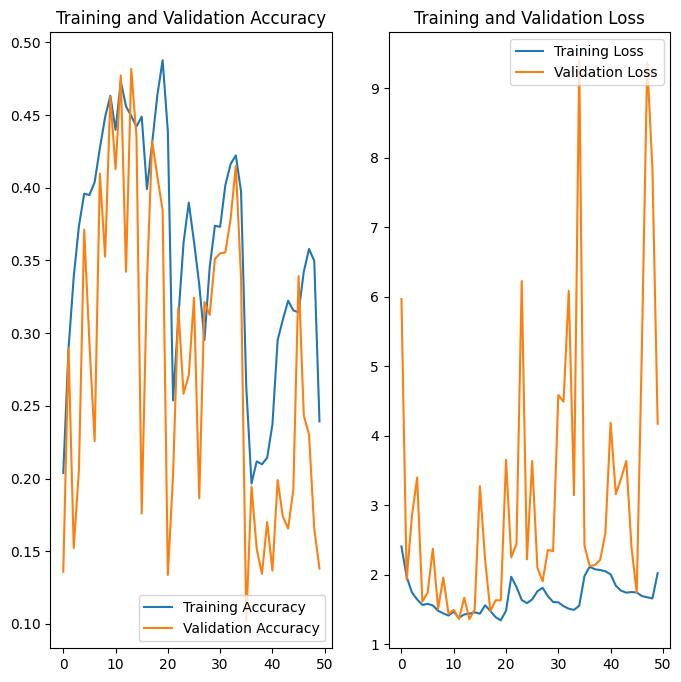

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion:**

Overfitting problem is not there now, we can see training and validation accuracy are similar and decently high.
Re-balancing the classes by using augmented data helps in improving model performance and accuracy

